# RNN-LSTM_tuto_3 : melody generator

In [3]:
import tensorflow.keras as keras
import json
import numpy as np
import music21 as m21
from datetime import datetime

### Paramètres

In [1]:
MODEL_PATH = "model_RNN_LSTM.keras"
SEQUENCE_LENGTH = 64
MAPPING_PATH = "data/han/mapping.json"
SAVE_GENERATED_MELODIES_DIR = "generated_melodies/RNN-LSTM"

### Load model and mapping file

In [4]:
# load model
print(MODEL_PATH)
model = keras.models.load_model(MODEL_PATH)

# start symboles
start_symbols = ["/"] * SEQUENCE_LENGTH

# mappings
with open(MAPPING_PATH, "r") as fp:
    mappings = json.load(fp)

model_RNN_LSTM.keras


### Generate melody

In [6]:
def sample_with_temperature(probabilites, temperature):
    """Samples an index from a probability array reapplying softmax using temperature

    :param predictions (nd.array): Array containing probabilities for each of the possible outputs.
    :param temperature (float): Float in interval [0, 1]. Numbers closer to 0 make the model more deterministic.
        A number closer to 1 makes the generation more unpredictable.

    :return index (int): Selected output symbol
    """
    predictions = np.log(probabilites) / temperature
    probabilites = np.exp(predictions) / np.sum(np.exp(predictions))

    choices = range(len(probabilites)) # [0, 1, 2, 3]
    index = np.random.choice(choices, p=probabilites)

    return index

In [7]:
def generate_melody(model, start_symbols, mappings, seed, num_steps, max_sequence_len, temperature):
    """Generates a melody using the DL model and returns a midi file.

        :param seed (str): Melody seed with the notation used to encode the dataset
        :param num_steps (int): Number of steps to be generated
        :param max_sequence_len (int): Max number of steps in seed to be considered for generation
        :param temperature (float): Float in interval [0, 1]. Numbers closer to 0 make the model more deterministic.
            A number closer to 1 makes the generation more unpredictable.

        :return melody (list of str): List with symbols representing a melody
    """

    # create seed with start symbols
    seed = seed.split()
    melody = seed
    seed = start_symbols + seed

    # map seed to int
    seed = [mappings[symbol] for symbol in seed]

    for _ in range(num_steps):
        # limit the seed to max_sequence_length
        seed = seed[-max_sequence_len:]
        
        # one-hot encode the seed
        onehot_seed = keras.utils.to_categorical(seed, num_classes=len(mappings))
        # (1, max_sequence_length, num of symbols in the vocabulary)
        onehot_seed = onehot_seed[np.newaxis, ...]

        # make a prediction
        probabilities = model.predict(onehot_seed)[0]
        # [0.1, 0.2, 0.1, 0.6] -> 1
        output_int = sample_with_temperature(probabilities, temperature)

        # update seed
        seed.append(output_int)

        # map int to our encoding
        output_symbol = [k for k, v in mappings.items() if v == output_int][0]

        # check whether we're at the end of a melody
        if output_symbol == "/":
            break

        # update melody
        melody.append(output_symbol)

    return melody



In [12]:
# On défini le début de la mélodie
#seed = "55 _ _ _" 
seed = "55 _ _ _ 60 _ _ _ 55 _ _ _ 55 _"


# Générer 10 mélodies
melodies = []
for _ in range (10):
    melodies.append(generate_melody(model, start_symbols, mappings, seed, 500, SEQUENCE_LENGTH, 0.7))


print(melodies[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

### Convert to midi file

In [13]:
def convert_to_midi(melody, step_duration=0.25):
    """Converts a melody into a MIDI stream

    :param melody (list of str):
    :param min_duration (float): Duration of each time step in quarter length
    :return: midi stream
    """

    # create a music21 stream
    stream = m21.stream.Stream()

    start_symbol = None
    step_counter = 1

    # parse all the symbols in the melody and create note/rest objects
    for i, symbol in enumerate(melody):

        # handle case in which we have a note/rest
        if symbol != "_" or i + 1 == len(melody):

            # ensure we're dealing with note/rest beyond the first one
            if start_symbol is not None:

                quarter_length_duration = step_duration * step_counter # 0.25 * 4 = 1

                # handle rest
                if start_symbol == "r":
                    m21_event = m21.note.Rest(quarterLength=quarter_length_duration)

                # handle note
                else:
                    m21_event = m21.note.Note(int(start_symbol), quarterLength=quarter_length_duration)

                stream.append(m21_event)

                # reset the step counter
                step_counter = 1

            start_symbol = symbol

        # handle case in which we have a prolongation sign "_"
        else:
            step_counter += 1

    return stream
    # # write the m21 stream to a midi file
    # stream.write(format, file_name)

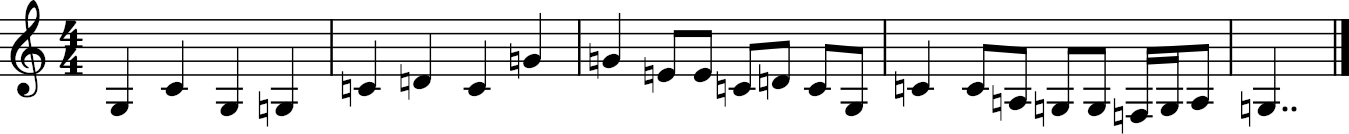

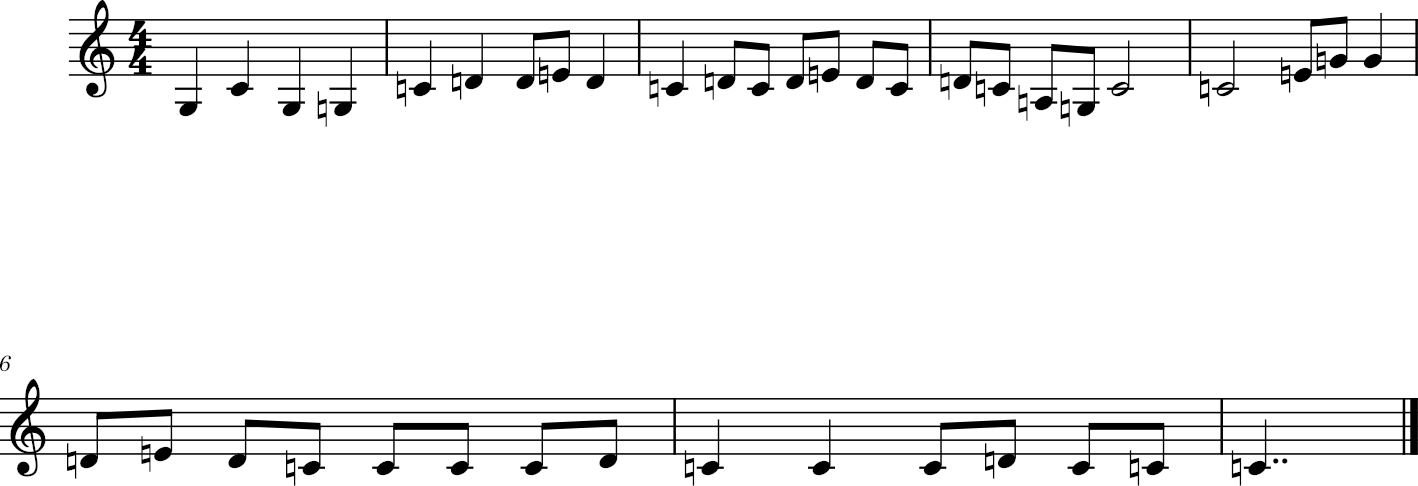

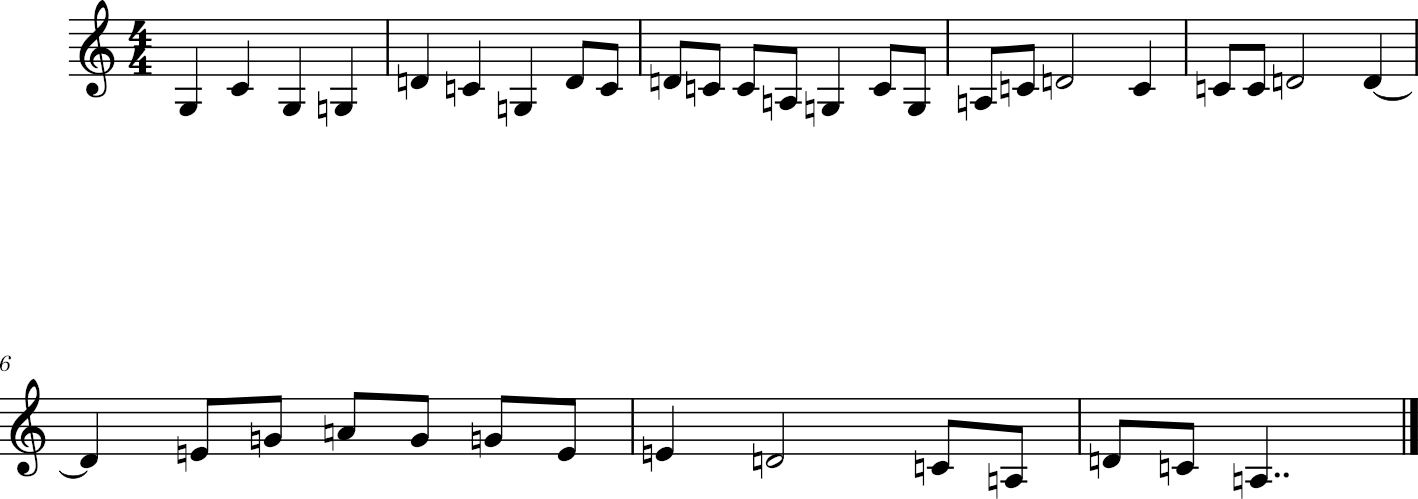

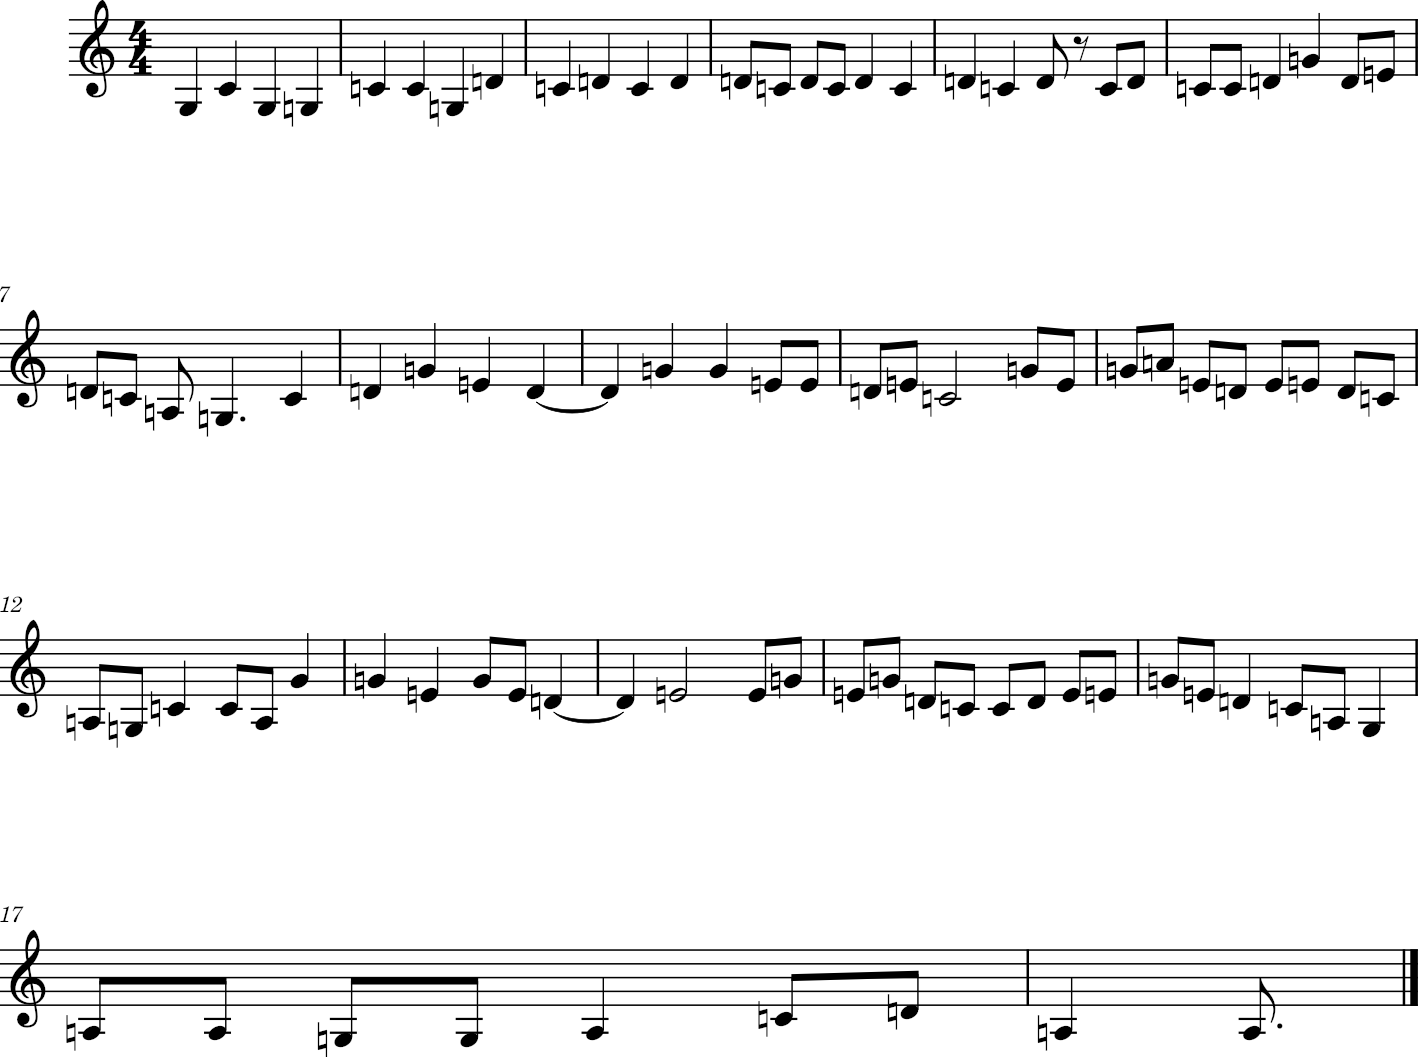

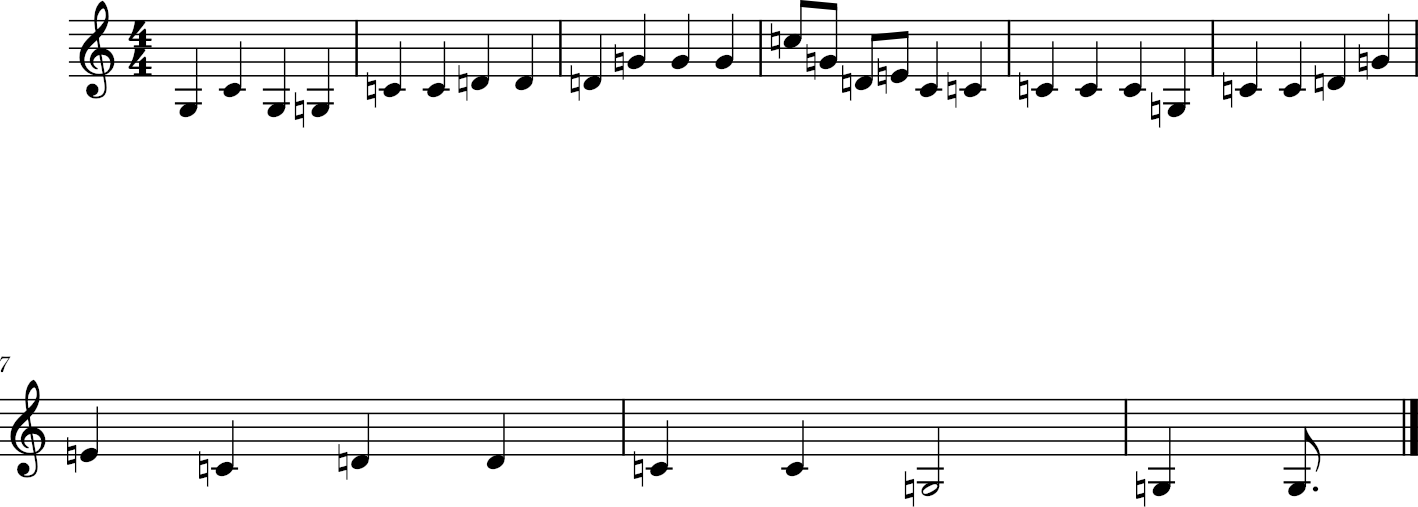

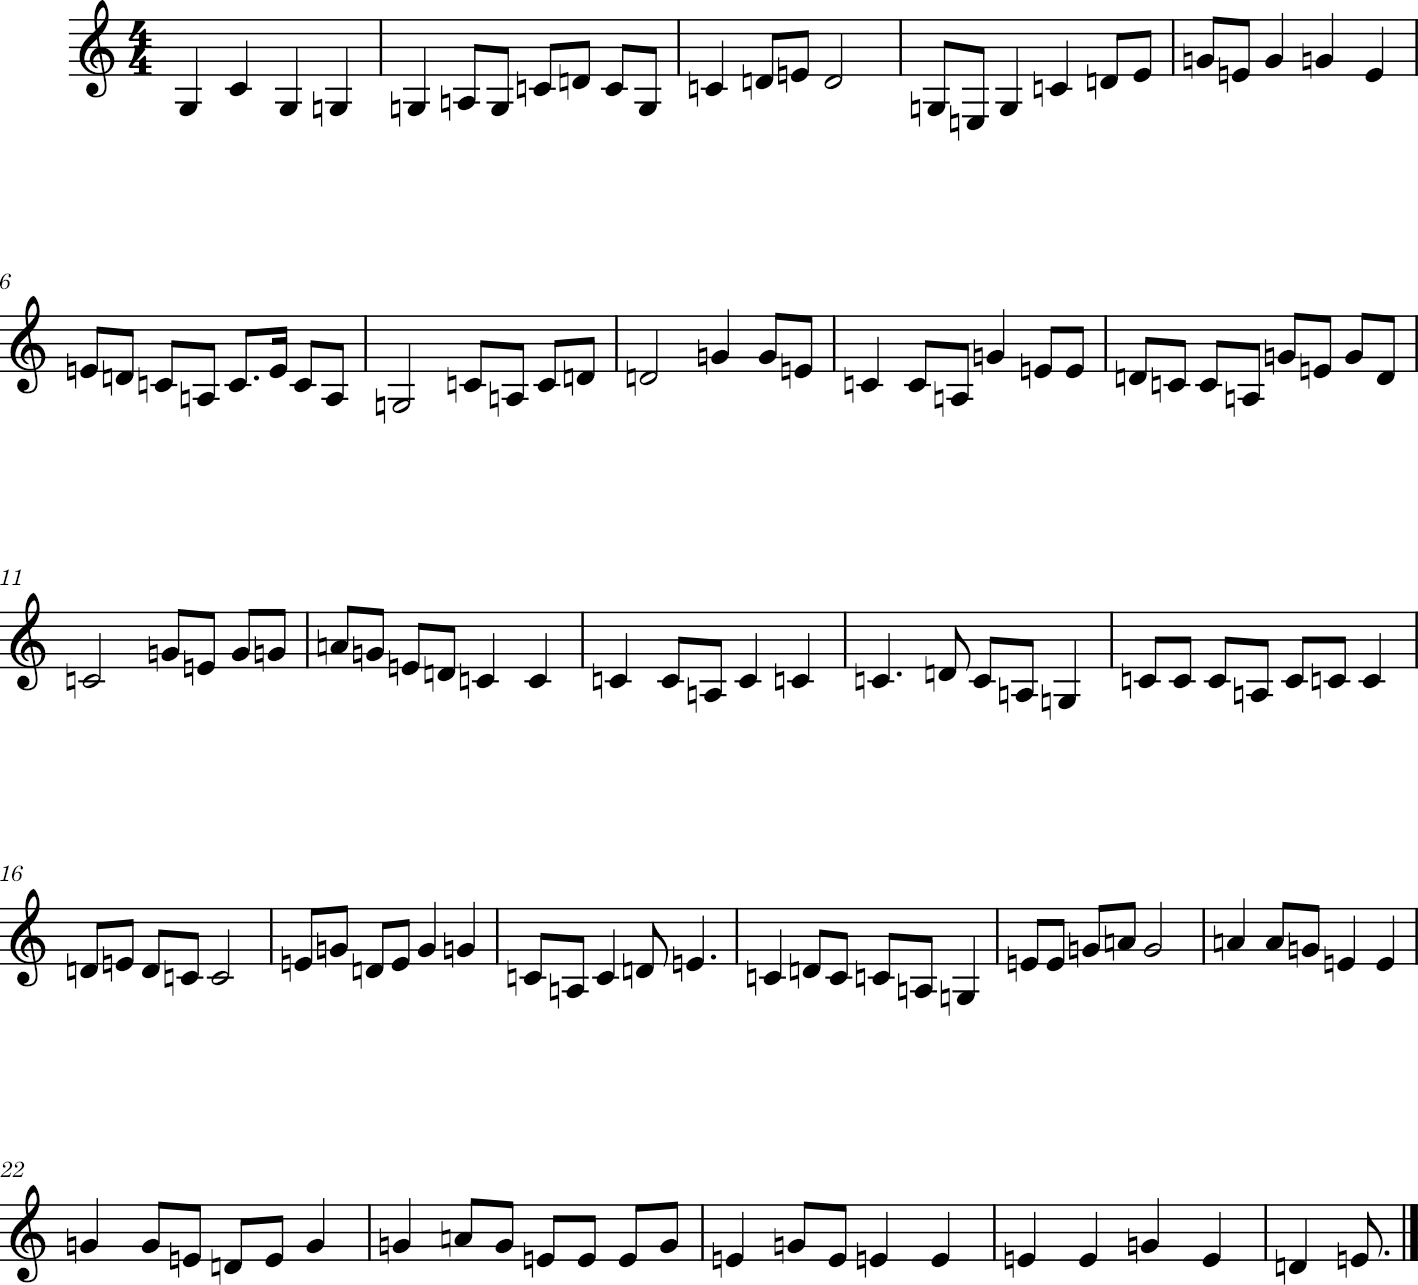

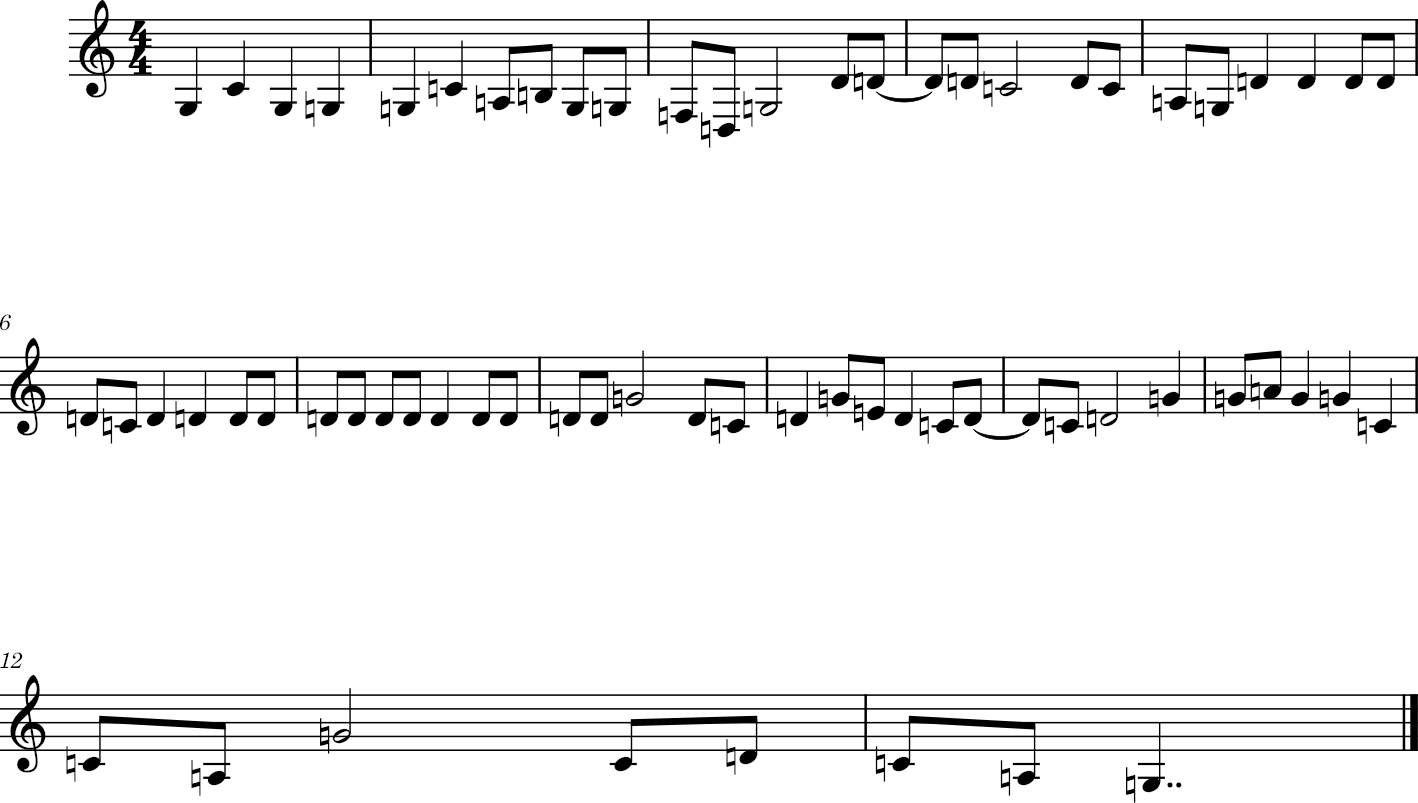

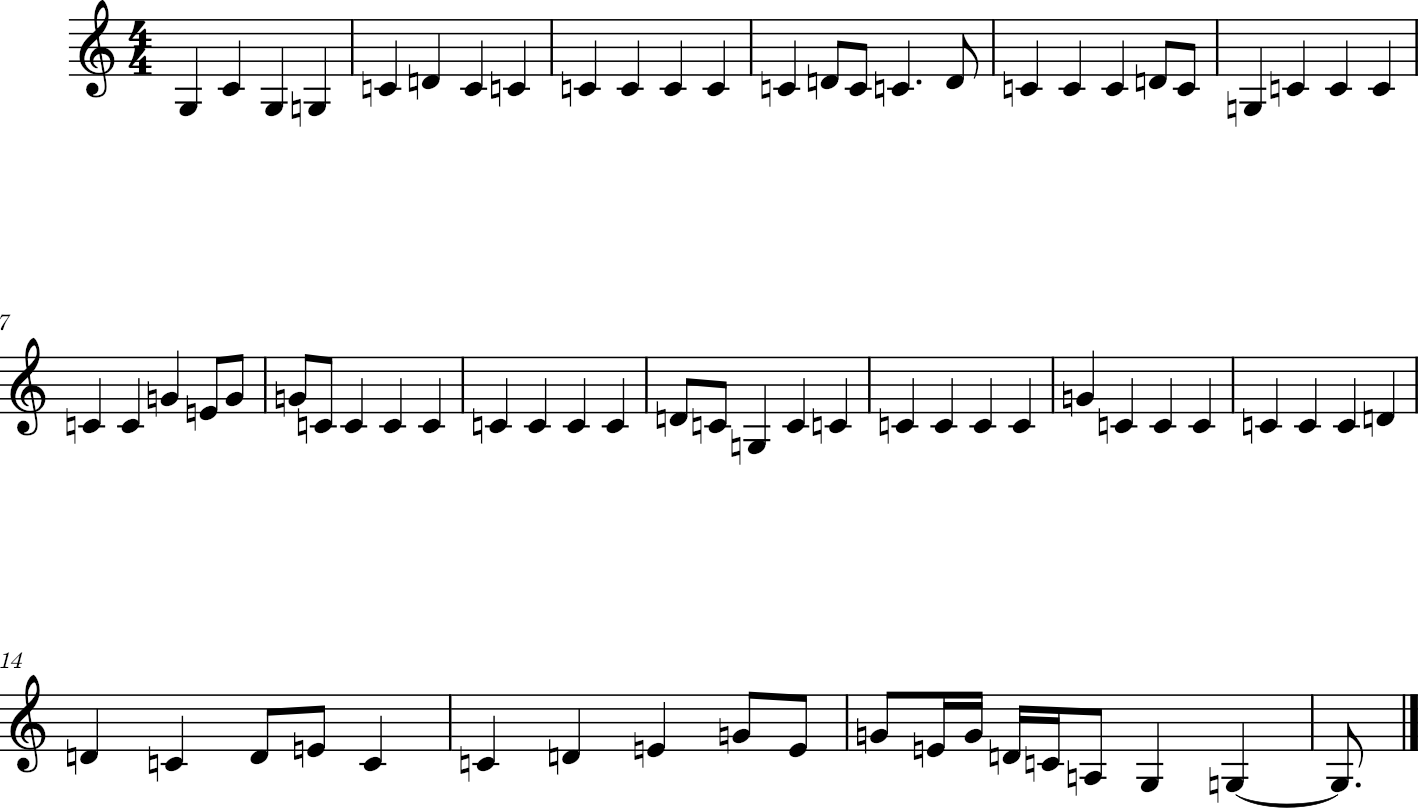

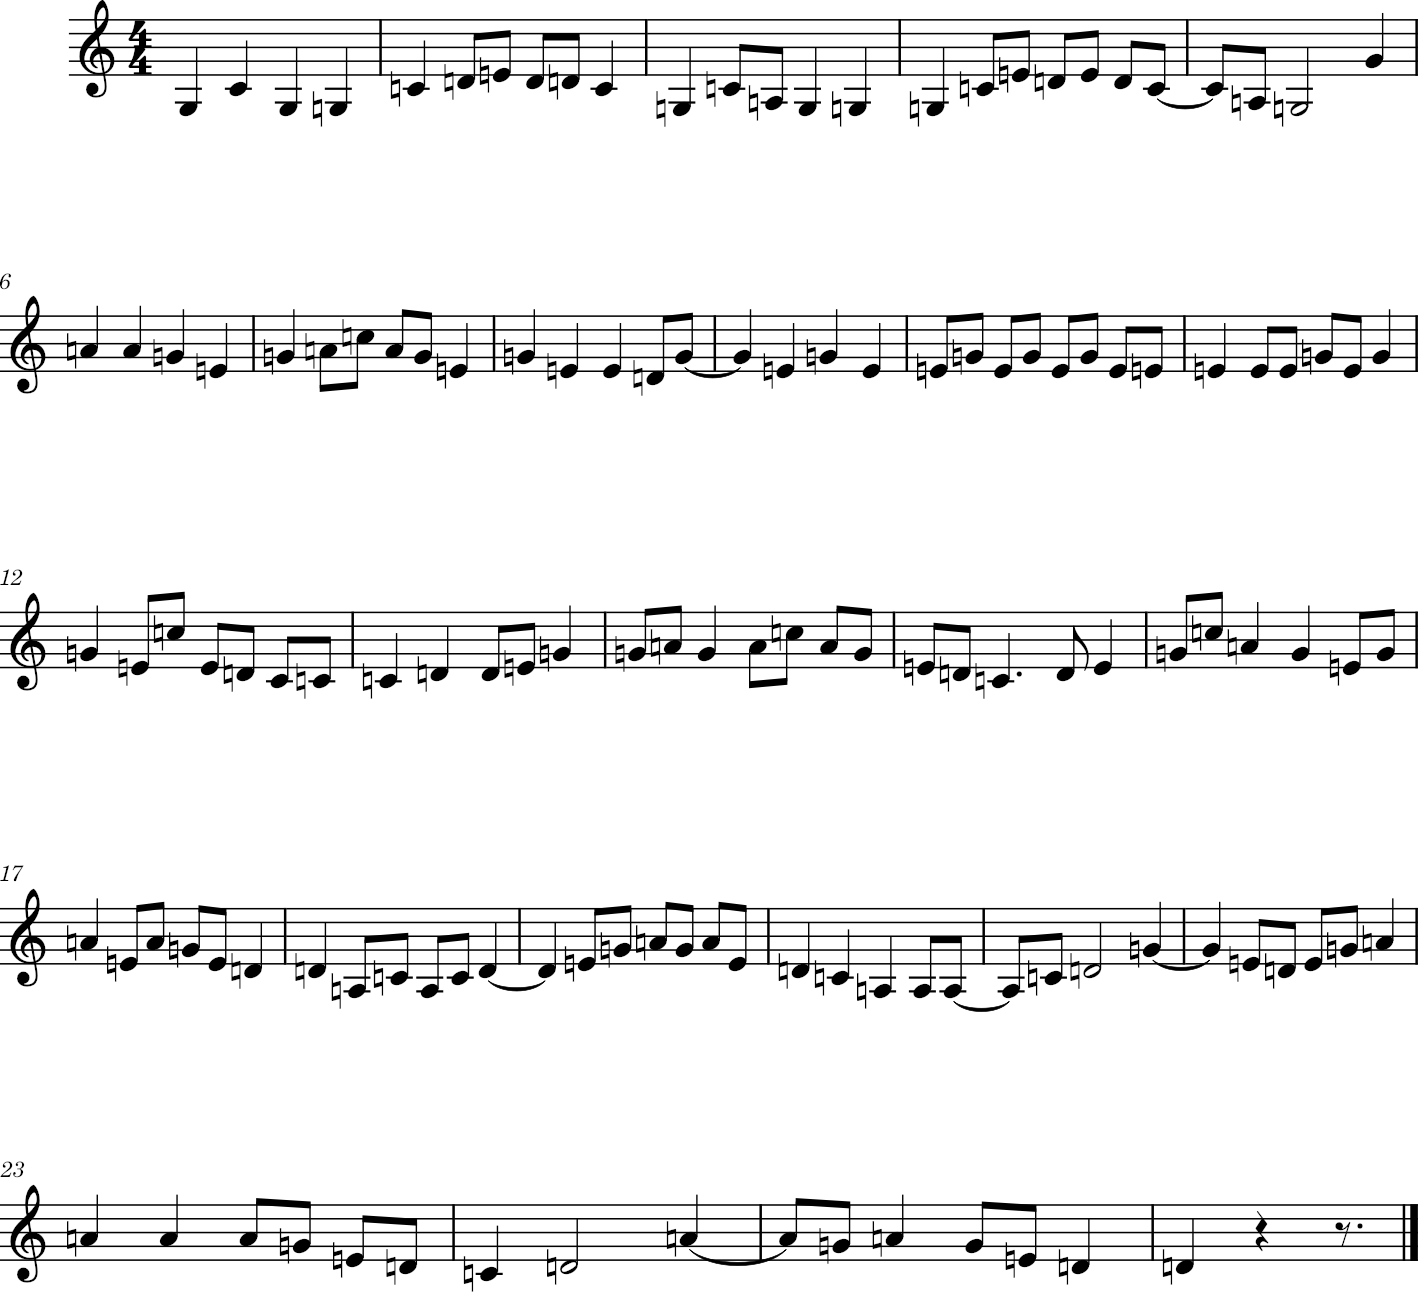

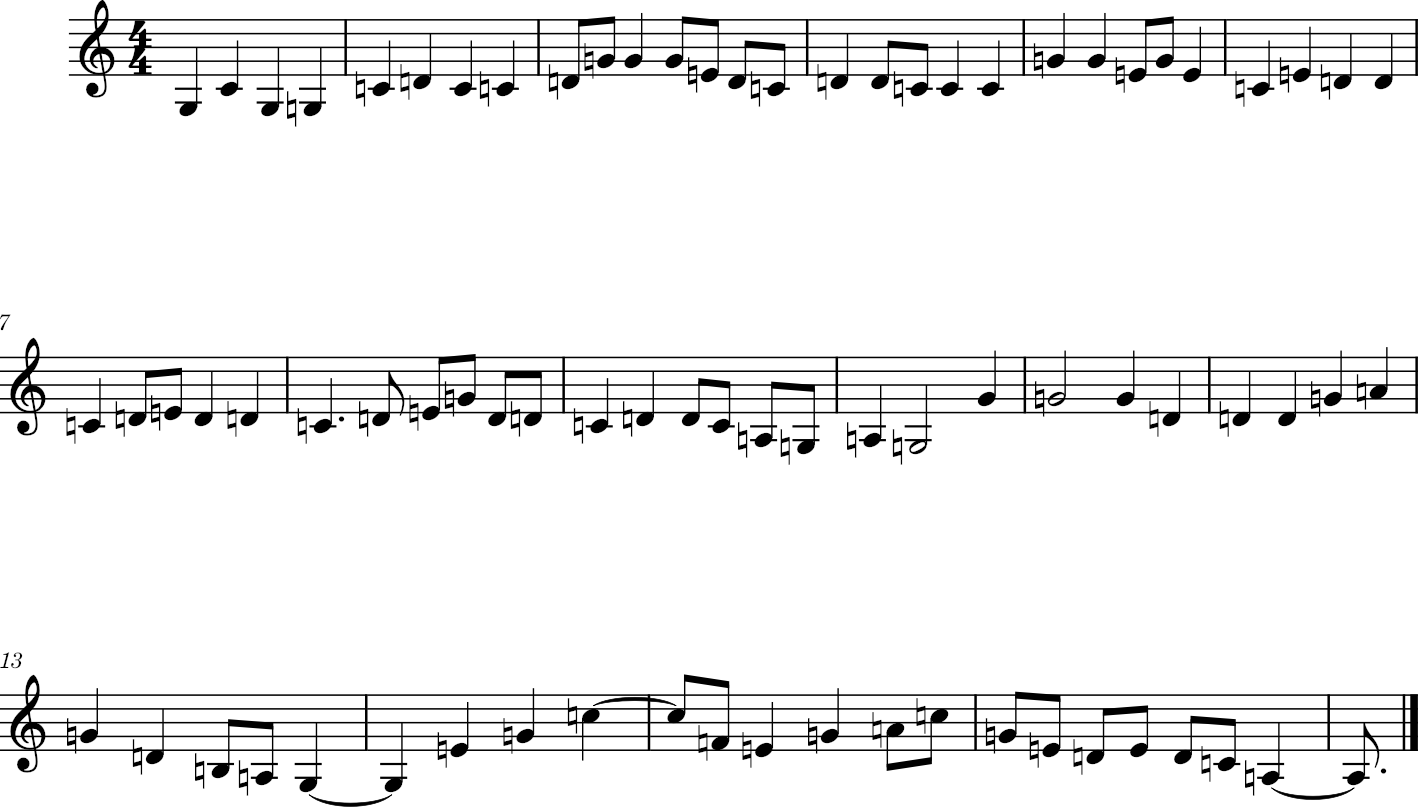

In [14]:
songs = []
for i in range(10):
    songs.append(convert_to_midi(melodies[i]))

for song in songs:
    song.show("midi")
    song.show()


In [15]:
# save
timestamp = datetime.now().strftime("%d%m_%H%M%S")  # Format sauvegarde : JJMM_HHMMSS_i
for i in range(10):
    songs[i].write("midi", SAVE_GENERATED_MELODIES_DIR + f"/{timestamp}_{i}.mid")